In [1]:
!mkdir -p /scratch/sagarsj42/torch-cache
!mkdir -p /scratch/sagarsj42/transformers
!mkdir -p /scratch/sagarsj42/hf-datasets

import os
os.chdir('/scratch/sagarsj42')
os.environ['TORCH_HOME'] = '/scratch/sagarsj42/torch-cache'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/sagarsj42/hf-datasets'

In [2]:
import random
import string

import datasets
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import transformers
from transformers import BertTokenizer, BertModel

2021-12-10 22:41:48.998080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-10 22:41:48.998122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
transformers.logging.set_verbosity_error()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
# Copied from explore_wikiqa.ipynb
def get_valid_questions(wikiqa):
    question_status = dict()

    for split in wikiqa:
        split_dataset = wikiqa[split]
        n_samples = len(split_dataset)

        for i in range(n_samples):
            qid = split_dataset[i]['question_id']
            label = split_dataset[i]['label']
            if qid not in question_status:
                question_status[qid] = label
            else:
                question_status[qid] = max(question_status[qid], label)

    valid_questions = set([qid for qid in question_status if question_status[qid] > 0])
    
    return valid_questions

In [5]:
class AS2Dataset(Dataset):
    def __init__(self, as2, name, tokenizer, max_length):
        super(AS2Dataset, self).__init__()
        self.as2 = as2
        self.name = name
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        if name == 'wikiqa':
            self.sentence_key = 'answer'
        else:
            self.sentence_key = 'sentence'
        
    def __len__(self):
        return len(self.as2)
    
    def __getitem__(self, idx):
        sample = self.as2[idx]
        question = sample['question'].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        sentence = sample[self.sentence_key].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        label = sample['label'] * 1.0
        
        input_enc = tokenizer(text=question, text_pair=sentence, 
                              add_special_tokens=True, truncation=True, padding='max_length', 
                              max_length=self.max_length, 
                              return_tensors='pt', return_attention_mask=True)
        
        if self.name == 'wikiqa':
            return (sample['question_id'], question, sentence, 
                    input_enc['input_ids'].flatten(), input_enc['attention_mask'].flatten(), 
                    input_enc['token_type_ids'].flatten(), 
                    label)
        else:
            return (question, sentence, input_enc['input_ids'].flatten(), 
                    input_enc['attention_mask'].flatten(), input_enc['token_type_ids'].flatten(), 
                    label)

In [6]:
class TandaTransfer(nn.Module):
    def __init__(self, encoder):
        super(TandaTransfer, self).__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(768, 1),
            nn.Dropout(p=0.25)
        )
        
    def forward(self, x):
        a = x[1]
        x = self.encoder(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2]).last_hidden_state
        x = (x * a.unsqueeze(-1) / a.sum(1).view(-1, 1, 1)).sum(1)
        x = self.layers(x)
        
        return x

In [7]:
asnq = datasets.load_dataset('asnq')
asnq

Using custom data configuration default
Reusing dataset asnq (/scratch/sagarsj42/hf-datasets/asnq/default/1.0.0/9d1e778b346e77ce06267638bbcb8745661548238317f5ebf8c821d530ac9fad)


DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 20377568
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 930062
    })
})

In [49]:
asnq_f = asnq.filter(lambda sample: 
                     sample['sentence_in_long_answer'] or sample['short_answer_in_sentence'])
asnq_f.save_to_disk('asnq-2-3')
asnq_f

Loading cached processed dataset at /scratch/sagarsj42/hf-datasets/asnq/default/1.0.0/9d1e778b346e77ce06267638bbcb8745661548238317f5ebf8c821d530ac9fad/cache-a4b02f30f9786ce4.arrow
Loading cached processed dataset at /scratch/sagarsj42/hf-datasets/asnq/default/1.0.0/9d1e778b346e77ce06267638bbcb8745661548238317f5ebf8c821d530ac9fad/cache-4bd2b2633cd4423c.arrow


DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 931448
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 59658
    })
})

In [58]:
asnq_f = datasets.load_from_disk('asnq-2-3')
asnq_f

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 931448
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 59658
    })
})

In [67]:
train_indices = random.sample(range(len(asnq_f['train'])), 10000)
dev_indices = random.sample(range(len(asnq_f['validation'])), 400)

asnq_ff = dict()
asnq_ff['train'] = asnq_f['train'].select(train_indices)
asnq_ff['validation'] = asnq_f['validation'].select(dev_indices)
asnq_f = asnq_ff
asnq_f

{'train': Dataset({
     features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
     num_rows: 10000
 }),
 'validation': Dataset({
     features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
     num_rows: 400
 })}

In [30]:
wikiqa = datasets.load_dataset('wiki_qa')
valid_questions = get_valid_questions(wikiqa)
wikiqa_f = wikiqa.filter(lambda sample: sample['question_id'] in valid_questions)

wikiqa_f

Using custom data configuration default
Reusing dataset wiki_qa (/scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c)
Loading cached processed dataset at /scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c/cache-bf93364f4fb44939.arrow
Loading cached processed dataset at /scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c/cache-da0e19c0403e394c.arrow
Loading cached processed dataset at /scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c/cache-d81b33fd0c2c62f9.arrow


DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2351
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 1130
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 8672
    })
})

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoder = BertModel.from_pretrained('bert-base-uncased')
encoder

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [68]:
tok_lengths = list()

for sample in asnq_f['train']:
    question = sample['question']
    sentence = sample['sentence']
    tok_len = min(256, len(tokenizer(text=question, text_pair=sentence)['input_ids']))
    tok_lengths.append(tok_len)
    
len(tok_lengths)

10000

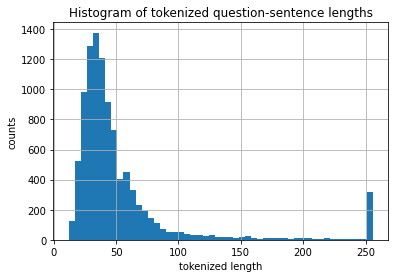

In [69]:
plt.hist(tok_lengths, density=False, bins=50)
plt.xlabel('tokenized length')
plt.ylabel('counts')
plt.title('Histogram of tokenized question-sentence lengths')
plt.grid()
plt.show()

In [70]:
asnq_train_ds = AS2Dataset(asnq_f['train'], 'asnq', tokenizer, max_length=128)
asnq_train_ds[0]

('who hit the first mlb interleague home run in 1997',
 'texas s darren oliver threw the game s first pitch and san francisco outfielder glenallen hill was the first designated hitter used in a regular  season game by a national league team',
 tensor([  101,  2040,  2718,  1996,  2034, 10901,  6970, 19738,  9077,  2188,
          2448,  1999,  2722,   102,  3146,  1055, 12270,  6291,  4711,  1996,
          2208,  1055,  2034,  6510,  1998,  2624,  3799, 21033,  8904, 24164,
          2078,  2940,  2001,  1996,  2034,  4351, 18694,  2109,  1999,  1037,
          3180,  2161,  2208,  2011,  1037,  2120,  2223,  2136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,   

In [71]:
batch_size = 16
transfer_epochs = 2
transfer_learning_rate = 1e-6

criterion = nn.BCEWithLogitsLoss()
criterion

BCEWithLogitsLoss()

In [72]:
def train_epochs_asnq(n_epochs, dataloader, model, optimizer, criterion, 
                      dev_dataloader=None, eval_steps=10000, save_path='./best.pth', device='cpu'):
    model.train()
    n_batches = len(dataloader)
    best_loss = float('inf')
    
    for epoch in range(n_epochs):
        total_loss = 0.0
        for step, sample in enumerate(dataloader):
            sample = sample[2:6]
            sample = [s.to(device) for s in sample]
            optimizer.zero_grad()
            output = model(sample[:-1])
            loss = criterion(output.flatten(), sample[-1].flatten())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if step > 0 and step % eval_steps == 0:
                dev_loss = validate_asnq(dev_dataloader, model, criterion, device=device)
                if dev_loss < best_loss:
                    best_loss = dev_loss
                    torch.save(model.state_dict(), save_path)
                    print(f'Best checkpoint saved at epoch {epoch+1}, step {step}, dev loss: {dev_loss:.4f}')
                step_loss = 0.0
        
        total_loss /= n_batches
        print(f'Epoch {epoch+1} complete. Train loss: {total_loss:.4f}')
    
    return total_loss

def validate_asnq(dataloader, model, criterion, device='cpu'):
    model.eval()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[2:6]
        sample = [s.to(device) for s in sample]
        output = model(sample[:-1])
        loss = criterion(output.flatten(), sample[-1].flatten())
        total_loss += loss.item()
        
    return total_loss / n_batches

In [73]:
asnq_train_ds = AS2Dataset(asnq_f['train'], 'asnq', tokenizer, max_length=128)
asnq_dev_ds = AS2Dataset(asnq_f['validation'], 'asnq', tokenizer, max_length=128)

len(asnq_train_ds), len(asnq_dev_ds)

(10000, 400)

In [74]:
asnq_train_dl = DataLoader(asnq_train_ds, batch_size=batch_size, shuffle=True)
asnq_dev_dl = DataLoader(asnq_dev_ds, batch_size=batch_size, shuffle=False)

len(asnq_train_dl), len(asnq_dev_dl)

(625, 25)

In [18]:
model = TandaTransfer(encoder)
model.to(DEVICE)
model = nn.DataParallel(model)

optimizer = Adam(model.parameters(), lr=transfer_learning_rate)

In [75]:
train_loss = train_epochs_asnq(transfer_epochs, asnq_train_dl, model, optimizer, criterion, 
                               dev_dataloader=asnq_dev_dl, eval_steps=100, save_path='best-transfer.pth', 
                               device=DEVICE)
train_loss

Best checkpoint saved at epoch 1, step 100, dev loss: 0.2942
Best checkpoint saved at epoch 1, step 200, dev loss: 0.2882
Best checkpoint saved at epoch 1, step 500, dev loss: 0.2875
Best checkpoint saved at epoch 1, step 600, dev loss: 0.2845
Epoch 1 complete. Train loss: 0.2422
Best checkpoint saved at epoch 2, step 100, dev loss: 0.2812
Best checkpoint saved at epoch 2, step 200, dev loss: 0.2739
Best checkpoint saved at epoch 2, step 500, dev loss: 0.2661
Epoch 2 complete. Train loss: 0.1879


0.1879481357768178

In [76]:
model.eval()
sample = next(iter(asnq_dev_dl))
sample = sample[2:6]
sample = [s.to(DEVICE) for s in sample]
output = model(sample[:-1]).detach()
nn.Sigmoid()(output)

tensor([[0.0198],
        [0.0466],
        [0.0066],
        [0.0126],
        [0.1641],
        [0.0944],
        [0.0576],
        [0.0231],
        [0.0027],
        [0.0148],
        [0.0078],
        [0.0922],
        [0.0024],
        [0.0500],
        [0.0072],
        [0.0195]], device='cuda:0')

In [21]:
next(iter(asnq_train_dl))[-1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [60]:
for d in asnq_f['train']:
#     print(d)
    print(d['label'], d['sentence_in_long_answer'], d['short_answer_in_sentence'])

0 False True
0 True False
0 True False
0 True False
0 True False
1 True True
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
1 True True
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
1 True True
0 True False
0 True False
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
1 True True
0 False True
0 False True
0 False True
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 True False
0 True False
1 True True
0 True False
0 True False
0 False True
0 True False
0 True False
0 True False
1 True True
0 False True
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
0 Tru

0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
1 True True
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 False True
0 True False
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
1 True True
0 False True
0 True False
1 True True
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 False True
0 True False
0 False True
1 True True
0 False True
0 True False
0 True False
0 False True
0 False True
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 T

0 True False
1 True True
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
1 True True
0 True False
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
1 True True
0 True False
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
1 True True
0 False True
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 False True
0 False True
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
0 True False
0 True False
0 False True
1 True True
0 False True
0 True False
0 False True
0 True False
0 False True
0 True False
0 False True
0 False True
0 Fa

0 False True
0 True False
0 False True
0 False True
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
1 True True
0 False True
0 True False
0 False True
1 True True
0 True False
0 False True
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 False True
0 False True
1 True True
0 False True
0 False True
0 True False
0 False True
0 True False
1 True True
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
1 True True
1 True True
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
1 True True
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 Fals

0 True False
0 True False
1 True True
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 False True
1 True True
0 True False
0 False True
0 False True
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 True False
1 True True
0 False True
0 True False
0 True False
0 True False
0 True False
1 True True
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
1 True True
0 False True
0 False True
0 True False
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
1 True True
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 True False
0 True False
0 Fal

0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
1 True True
0 True False
1 True True
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 True False
0 False True
0 False True
0 True False
0 False True
0 True False
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 False True
0 False True
0 True False
0 False True
1 True True
0 True False
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
1 

0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
0 True False
0 True False
1 True True
0 False True
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
1 True True
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
1 True True
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 False True
0 False True
0 True False
1 True True
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 False True
0 False True
0 True False
0 F

0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
1 True True
0 False True
0 True False
0 False True
0 False True
0 True False
0 False True
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 True False
1 True True
0 False True
0 False True
0 True False
0 False True
1 True True
0 False True
0 True False
0 True False
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 False True
1 True True
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
0 False True
0 True False
1 T

0 False True
0 True False
0 False True
0 False True
0 False True
0 False True
1 True True
0 True False
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
1 True True
0 True False
0 True False
0 True False
0 False True
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 True False
0 False True
1 True True
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 True False
0 True False
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
0 False True
0 True False
0 False True
0 False True
0 True False
0 True False
0 True False
0 False True
0 True False
0 True False
0 False True
0 True False
0 False True
0 True False
0 False True
0 False True
0 False True
0 True False
0 True False
0 False True
0 False True
0 False True
0 True False
0 False True
1 True True
0 True False
0 False True
0 True False
0 T